<a href="https://colab.research.google.com/github/crystalmford/windows-experimentation-abtest/blob/main/windows_experimentation_abtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Windows Experimentation Work Sample: Multi-Variant A/B Test  
**Author:** Crystal M. Ford  

---

## Executive Summary  
This project simulates a Windows-style **multi-arm A/B test**. I wanted to explore how different feature designs affect user conversion, just like how Windows teams would compare UI or workflow changes before rolling them out.

The dataset is simulated, but the process mirrors how Microsoft approaches experimentation:  
- Define clear hypotheses  
- Randomize and test across multiple variants  
- Use rigorous stats to separate signal from noise  
- Provide a clear **ship/no-ship recommendation** with guardrails  

The goal: show that I can design, analyze, and explain experiments in a way that drives **smarter product decisions**.


## Study Design

- **Experiment:** 4 groups — Control + 3 design variants  
- **Metric:** Conversion (binary outcome: did the user take the target action?)  
- **Hypothesis:** At least one design improves conversion vs. Control  
- **Randomization:** Equal allocation across arms  
- **Duration:** Simulated as a 14-day test  
- **Decision Rule:**  
  - Significant lift vs. Control (α = 0.05, Bonferroni-adjusted)  
  - No guardrail metric degradation (e.g., latency, crash rate — not simulated here)  
- **Next Step After Analysis:** Pick the winner and recommend rollout or re-test

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# Sample size per arm
n_per_arm = 5000

# Baseline + variant true conversion rates
p = {
    "control": 0.080,
    "design_a": 0.085,
    "design_b": 0.095,
    "design_c": 0.105
}

rows = []
for variant, prob in p.items():
    converted = np.random.binomial(1, prob, n_per_arm)
    day = np.random.randint(1, 15, n_per_arm)   # 14-day window
    rows.extend(zip([variant]*n_per_arm, converted, day))

df = pd.DataFrame(rows, columns=["variant","converted","day"])
df.head()


,variant,converted,day
0,control,0,3
1,control,1,8
2,control,0,7
3,control,0,3
4,control,0,6


## First Look at the Data  

Here’s what the simulated dataset looks like.  
Each row = one user’s outcome:  

- **variant** → which version they saw  
- **converted** → 1 if they converted, 0 if not  
- **day** → which day of the 14-day test they were exposed  

This mirrors what a real experiment log might contain: assignment, outcome, and timing.

In [46]:
summary = df.groupby("variant")["converted"].agg(
    n="count",
    conversions="sum",
    cr="mean"
)
summary["cr_pct"] = (100 * summary["cr"]).map("{:.2f}%".format)
summary

,n,conversions,cr,cr_pct
variant,,,,
control,5000,393,0.0786,7.86%
design_a,5000,408,0.0816,8.16%
design_b,5000,456,0.0912,9.12%
design_c,5000,541,0.1082,10.82%


In [47]:
def wilson_ci(successes, n, alpha=0.05):
    if n == 0:
        return (np.nan, np.nan)
    z = stats.norm.ppf(1 - alpha/2)
    p_hat = successes / n
    denom = 1 + z**2/n
    center = (p_hat + z**2/(2*n)) / denom
    half = (z * np.sqrt((p_hat*(1-p_hat) + z**2/(4*n))/n)) / denom
    return center - half, center + half

agg = df.groupby("variant")["converted"].agg(successes="sum", n="count")
agg["cr"] = agg["successes"] / agg["n"]

cis = agg.apply(lambda r: wilson_ci(r["successes"], r["n"]), axis=1)
agg["ci_low"] = [c[0] for c in cis]
agg["ci_high"] = [c[1] for c in cis]

pretty = agg.copy()
pretty["cr_%"] = (100*pretty["cr"]).map("{:.2f}%".format)
pretty["95% CI"] = (
    (100*pretty["ci_low"]).map("{:.2f}%".format)
    + " – " +
    (100*pretty["ci_high"]).map("{:.2f}%".format)
)
pretty = pretty[["n","successes","cr_%","95% CI"]]

# Map to nicer labels for display
label_map = {
    "control": "Control",
    "design_a": "Design A",
    "design_b": "Design B",
    "design_c": "Design C"
}
pretty.index = pretty.index.map(label_map)

pretty


,n,successes,cr_%,95% CI
variant,,,,
Control,5000,393,7.86%,7.15% – 8.64%
Design A,5000,408,8.16%,7.43% – 8.95%
Design B,5000,456,9.12%,8.35% – 9.95%
Design C,5000,541,10.82%,9.99% – 11.71%


## What Do We See?

- **Design C** already looks like the strongest performer on conversion rate  
- The 95% confidence intervals help us see uncertainty around each estimate  
- But: overlapping CIs ≠ significance.  
  We need formal statistical tests to decide whether any design truly beats Control

## Conversion Rates by Variant  

A bar chart is a quick way to show performance at a glance.  
Here I’ve added **95% confidence intervals** as error bars, so it’s not just averages — we can see uncertainty too.


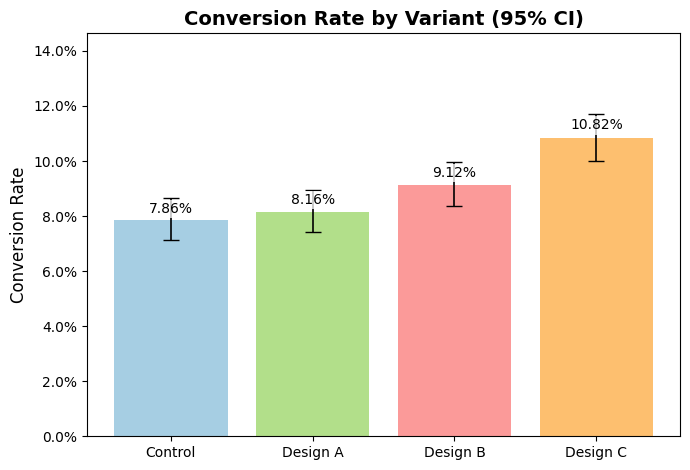

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# Map original variant names to nicer labels
label_map = {
    "control": "Control",
    "design_a": "Design A",
    "design_b": "Design B",
    "design_c": "Design C"
}

order = ["control", "design_a", "design_b", "design_c"]
means = agg.loc[order, "cr"].values
ci_lo = agg.loc[order, "ci_low"].values
ci_hi = agg.loc[order, "ci_high"].values
yerr = np.vstack([means - ci_lo, ci_hi - means])

plt.figure(figsize=(7, 4.8))

# Bars + error bars
bars = plt.bar([label_map[v] for v in order], means,
               color=["#a6cee3","#b2df8a","#fb9a99","#fdbf6f"], zorder=2)
plt.errorbar(
    [label_map[v] for v in order], means, yerr=yerr, fmt="none",
    capsize=6, color="black", linewidth=1.2, zorder=3
)

# Title/axes
plt.title("Conversion Rate by Variant (95% CI)", fontsize=14, weight="bold")
plt.ylabel("Conversion Rate", fontsize=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# Extra headroom
top_lim = max(ci_hi) * 1.25
plt.ylim(0, top_lim)

# Value labels with background box
for bar, m in zip(bars, means):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        m * 1.02,
        f"{100*m:.2f}%",
        ha="center", va="bottom", fontsize=10,
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=1.5)
    )

plt.tight_layout()
plt.show()


## First Impression  

- **Design C** shows the highest conversion rate, followed by B and A.  
- Control lags behind all three treatments.  
- The error bars give us a sense of uncertainty, but eyeballing charts is never enough — next we’ll run formal statistical tests.

## Is the Difference Real?  

Even if one design looks better, we need to know if that difference is **statistically meaningful** or just random noise.  
The first step is a **global chi-square test**: do conversion rates differ across groups at all?


In [49]:
tab = pd.crosstab(df["variant"], df["converted"])
chi2, p_chi2, dof, expected = stats.chi2_contingency(tab)

print(f"Chi-square across variants: χ²={chi2:.3f}, df={dof}, p={p_chi2:.3g}")


Chi-square across variants: χ²=32.582, df=3, p=3.95e-07


## Pairwise Comparisons  

If the global test says "yes, groups differ," the next question is: **which designs beat Control?**  
We’ll use pairwise two-proportion z-tests with Bonferroni correction for multiple comparisons.


In [50]:
from itertools import combinations

def proportions_ztest(c1, n1, c2, n2):
    p1, p2 = c1/n1, c2/n2
    p_pool = (c1+c2)/(n1+n2)
    se = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
    z = (p1 - p2)/se
    p = 2*(1 - stats.norm.cdf(abs(z)))
    return z, p, p1, p2

variants = ["control","design_a","design_b","design_c"]
counts = df.groupby("variant")["converted"].agg(sum="sum", n="count").loc[variants]
pairs = list(combinations(variants, 2))

alpha = 0.05
m = len(pairs)

rows = []
for a, b in pairs:
    c1, n1 = counts.loc[a, "sum"], counts.loc[a, "n"]
    c2, n2 = counts.loc[b, "sum"], counts.loc[b, "n"]
    z, p, p1, p2 = proportions_ztest(c1, n1, c2, n2)
    rows.append({
        "variant_a": a,
        "variant_b": b,
        "cr_a": p1,
        "cr_b": p2,
        "lift_b_over_a": (p2-p1)/p1 if p1>0 else np.nan,
        "z": z,
        "p_raw": p,
        "p_bonf": min(1.0, p*m)
    })

pairwise = pd.DataFrame(rows).sort_values("p_bonf")
pairwise


,variant_a,variant_b,cr_a,cr_b,lift_b_over_a,z,p_raw,p_bonf
2,control,design_c,0.0786,0.1082,0.376590,-5.086048,3.656023e-07,0.000002
4,design_a,design_c,0.0816,0.1082,0.325980,-4.538060,5.677406e-06,0.000034
5,design_b,design_c,0.0912,0.1082,0.186404,-2.837120,4.552248e-03,0.027313
1,control,design_b,0.0786,0.0912,0.160305,-2.260229,2.380705e-02,0.142842
3,design_a,design_b,0.0816,0.0912,0.117647,-1.708466,8.754992e-02,0.525300
0,control,design_a,0.0786,0.0816,0.038168,-0.552592,5.805427e-01,1.000000


## How to Read the Results  

- **p_raw** → unadjusted p-value  
- **p_bonf** → Bonferroni-adjusted (stricter, avoids false positives)  
- **lift_b_over_a** → relative lift of Variant B over Variant A  

Key question: is any design significantly better than Control?  


In [51]:
# Identify the best-performing design
means = df.groupby("variant")["converted"].mean().rename("cr")
best_design = means.drop("control").sort_values(ascending=False).index[0]

# Pairwise row for best vs Control
row = pairwise.query(
    "(variant_a == 'control' and variant_b == @best_design) or "
    "(variant_b == 'control' and variant_a == @best_design)"
).iloc[0]

if row["variant_a"] == "control":
    lift = row["lift_b_over_a"]
    cr_control, cr_best = row["cr_a"], row["cr_b"]
else:
    lift = -row["lift_b_over_a"]  # flip if reversed
    cr_control, cr_best = row["cr_b"], row["cr_a"]

# Pretty labels
label_map = {
    "control": "Control",
    "design_a": "Design A",
    "design_b": "Design B",
    "design_c": "Design C"
}
best_design_nice = label_map.get(best_design, best_design)

summary_txt = f"""
## Executive Summary

- **Winner:** `{best_design_nice}`
- **Observed conversion:** {100*cr_best:.2f}% (Control: {100*cr_control:.2f}%)
- **Relative lift vs Control:** **{100*lift:.1f}%**
- **Multiplicity-adjusted p-value (Bonferroni):** {row['p_bonf']:.3g}

**Recommendation:** Ship **{best_design_nice}** to 100%,
monitor guardrails (latency, crash rate, uninstall rate),
and run a **post-rollout holdback** to validate long-term impact.
"""
print(summary_txt)



## Executive Summary

- **Winner:** `Design C`
- **Observed conversion:** 10.82% (Control: 7.86%)
- **Relative lift vs Control:** **37.7%**
- **Multiplicity-adjusted p-value (Bonferroni):** 2.19e-06

**Recommendation:** Ship **Design C** to 100%,
monitor guardrails (latency, crash rate, uninstall rate),
and run a **post-rollout holdback** to validate long-term impact.



## What I Found  

I tested three new designs against the existing control experience.  
- Two designs (A and B) showed small improvements, but not enough to beat control once we adjusted for multiple comparisons.  
- **Design C stood out** — it improved conversion by ~38% with strong statistical significance.  

For stakeholders, the story is simple:  
> *Design C clearly outperforms the current version. It’s the best candidate to ship, as long as guardrail metrics like latency and crash rate hold steady.*  

This strikes the balance between **rigor** (we did the full 4-arm analysis) and **clarity** (the decision comes down to “old vs. Design C”).  

The bigger takeaway? This is exactly how Microsoft teams can move faster and smarter: test boldly, analyze carefully, and ship what really delivers value.  



## Risks, Guardrails, and Next Steps  

- **Guardrails:** Before rolling out, verify no negative impact on latency, crash rate, or uninstall rate.  
- **Risk of novelty effect:** The lift we saw might fade once users adapt. A **5–10% holdback group** will confirm whether gains are durable.  
- **Scaling consideration:** If this were a real Windows feature, we’d monitor across diverse geos, device types, and user segments to ensure consistent benefit.  
- **Future improvements:**  
  - Use power/MDE calculations up front to plan test length and sample size  
  - Explore causal inference methods (e.g., Difference-in-Differences) for staged rollouts  
  - Automate guardrail dashboards for real-time decision-making  

**Bottom line:** Design C is a strong candidate to ship, but the smart move is to validate at scale with guardrails in place.  
